### Instalação de bibliotecas necessárias para execução do código

Descomente se necessário

In [1]:
# pip install pandas, numpy, xgboost, lightgbm, scipy, matplotlib==3.7.1, seaborn==0.12.2
# pip install -U scikit-learn 


### Importação de bibliotecas e dados

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from scipy.sparse import csr_matrix

df_empresas_estab_mg = pd.read_csv("data/df_empresas_estab_mg.csv")
df_naturezas = pd.read_csv("data/Naturezas0.csv")
df_cnaes = pd.read_csv("data/Cnaes0.csv")
df_qualificacoes = pd.read_csv("data/Qualificacoes0.csv")

### Filtrando empresas criadas acima de 1900, pois existem algumas empresas com problema na data de inicio de atividade

In [3]:
df_empresas_estab_mg = df_empresas_estab_mg[df_empresas_estab_mg['DATA DE INÍCIO ATIVIDADE'] > '1900-01-01']

In [4]:
df_empresas_estab_mg['DATA DE INÍCIO ATIVIDADE'] = pd.to_datetime(df_empresas_estab_mg['DATA DE INÍCIO ATIVIDADE'])
df_empresas_estab_mg['IDADE'] = (pd.Timestamp('now') - df_empresas_estab_mg['DATA DE INÍCIO ATIVIDADE']) / np.timedelta64(1, 'D')

In [5]:
colunas_modelo = ['NATUREZA', 'CAPITAL', 'PORTE', 'IDENTIFICADOR MATRIZ/FILIAL', 'CNAE FISCAL PRINCIPAL', 'QUALIFICAÇÃO', 'IDADE']b

### Filtra as 30 categorias com mais empresas de cada variavel categórica, assim não é necessário criar uma coluna para cada atividade diferente

In [6]:
first = 30
first_naturezas = df_empresas_estab_mg.groupby('NATUREZA')['cnpj'].count().sort_values(ascending=False).head(first).index
first_cnaes = df_empresas_estab_mg.groupby('CNAE FISCAL PRINCIPAL')['cnpj'].count().sort_values(ascending=False).head(first).index
first_qualificacoes = df_empresas_estab_mg.groupby('QUALIFICAÇÃO')['cnpj'].count().sort_values(ascending=False).head(first).index

In [7]:
for column, list_ in zip(['NATUREZA', 'CNAE FISCAL PRINCIPAL', 'QUALIFICAÇÃO'], [first_naturezas, first_cnaes, first_qualificacoes]):
    df_empresas_estab_mg[column] = df_empresas_estab_mg[column].apply(lambda x: x if x in list_ else -1)

### Cria target e trata colunas a serem encodadas com one-hot encoder

In [8]:
df_empresas_estab_mg['target'] = df_empresas_estab_mg['SITUAÇÃO CADASTRAL'].apply(lambda x: 1 if x == 2 else 0)
df_empresas_estab_mg['CAPITAL'] = df_empresas_estab_mg['CAPITAL'].apply(lambda x: x.replace(',', '.')).astype(float)
colunas_encoder = ['NATUREZA', 'PORTE', 'IDENTIFICADOR MATRIZ/FILIAL', 'CNAE FISCAL PRINCIPAL', 'QUALIFICAÇÃO']
df_empresas_estab_mg[colunas_encoder] = df_empresas_estab_mg[colunas_encoder].fillna(0).astype(int)


### Separa em dados de treinamento e dados de teste. 20% dos dados são usados para teste.

In [9]:
x_train, x_test, y_train,y_test = train_test_split(df_empresas_estab_mg[colunas_modelo], df_empresas_estab_mg['target'], test_size=0.2, random_state=42)

In [10]:
x_train

,NATUREZA,CAPITAL,PORTE,IDENTIFICADOR MATRIZ/FILIAL,CNAE FISCAL PRINCIPAL,QUALIFICAÇÃO,IDADE
5263590,2135,1000.0,1,1,-1,50,1094.507573
4187327,4090,0.0,5,1,9492800,51,2388.507573
185614,2135,0.0,5,1,-1,50,11218.507573
2996784,2135,1000.0,1,1,-1,50,3420.507573
109853,2135,2200.0,1,1,4781400,50,660.507573
...,...,...,...,...,...,...,...
1570007,2062,0.0,1,1,5611201,49,6961.507573
2234490,2062,10000.0,1,1,4930202,49,4370.507573
4926485,2135,5000.0,1,1,-1,50,1445.507573
4304573,2135,10000.0,1,1,-1,50,2242.507573


In [11]:
x_test

,NATUREZA,CAPITAL,PORTE,IDENTIFICADOR MATRIZ/FILIAL,CNAE FISCAL PRINCIPAL,QUALIFICAÇÃO,IDADE
2098380,2135,1000.0,1,1,-1,50,4727.507573
4541210,2135,70000.0,1,1,-1,50,1899.507573
4108250,2062,0.0,1,1,-1,49,12409.507573
2253389,2062,10000.0,1,1,-1,49,4322.507573
4467910,2135,600.0,1,1,9602501,50,2016.507573
...,...,...,...,...,...,...,...
635145,2135,5000.0,1,1,4781400,50,225.507573
988641,3085,0.0,5,1,8112500,19,10536.507573
4998140,2321,3000.0,5,1,-1,65,1368.507573
4915302,2135,50000.0,1,1,-1,50,1454.507573


### Variaveis que não passarão por transformação

In [12]:
not_encoder = ['CAPITAL', 'IDADE']

In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
ohe = OneHotEncoder(handle_unknown='ignore')

ct = make_column_transformer(
    (ohe, colunas_encoder),
    remainder='passthrough'
)
ct.fit(x_train)

x_train_encoded = ct.transform(x_train)
x_test_encoded = ct.transform(x_test)



In [14]:
cols = list(ct.named_transformers_['onehotencoder'].get_feature_names_out()) + not_encoder

Cria dados a serem usados pelo XGBoost

In [15]:
dtrain = xgb.DMatrix(x_train_encoded, label=y_train)

In [16]:
x_train_data = x_train_encoded.todense()
y_train_data = y_train

In [17]:
%%time
param = { 'objective': 'binary:logistic'}
param['eval_metric'] = 'auc'

xgb_clf = xgb.train(params=param,dtrain=dtrain)

Wall time: 11.9 s


In [18]:
# Fazer previsões com o modelo
dtest = xgb.DMatrix(x_test_encoded)

In [19]:
y_pred = xgb_clf.predict(dtest)
y_pred

array([0.31458646, 0.42747876, 0.14117073, ..., 0.7254335 , 0.55421126,
       0.261133  ], dtype=float32)

### Da forma que o XGBoost foi treinado a predição será a probabilidade da instância ser da classe 1 - Empresa ativa

In [20]:
y_pred = [round(value) for value in y_pred]


Calcula e exibe acurácia do modelo treinado

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
ps = precision_score(y_test, y_pred)

In [22]:
print("Matriz de Confusão:\n", cm)
print("Acurácia: {:.2f}%".format(acc*100))
print("F1 Score: {:.2f}%".format(f1*100))
print("Precision: {:.2f}%".format(ps*100))


Matriz de Confusão:
 [[608153  92573]
 [168827 282788]]
Acurácia: 77.32%
F1 Score: 68.39%
Precision: 75.34%


### Define função a ser usada para visualização dos resultados

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

classes = ['Empresa fechada', 'Empresa ativa']
def plot_matriz(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cmap = sns.light_palette("green", as_cmap=True)

    dpi = 150
    fig = plt.figure(figsize=(10, 6), dpi=dpi)
    ax = plt.gca()
    im = ax.imshow(cm, cmap=cmap)

    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            text = ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)

    plt.show()
    
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    cm_bar = confusion_matrix(y_test, y_pred, normalize='true')*100
    cmap = sns.light_palette("green", as_cmap=True)
    
    cm_rounded = np.around(cm, decimals=4)

    cm_percent = np.vectorize(lambda x: '{:.2%}'.format(x))(cm_rounded)



    fig = plt.figure(figsize=(10, 6), dpi=dpi)
    ax = plt.gca()
    im = ax.imshow(cm_bar, cmap=cmap)

    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    
    for i in range(len(classes)):
        for j in range(len(classes)):
            text = ax.text(j, i, cm_percent[i, j], ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)

    plt.show()
    
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    ps = precision_score(y_test, y_pred)
    

    print("Matriz de Confusão:\n", cm)
    print("Matriz de confusao percent", cm_percent)
    print("Acurácia: {:.2f}%".format(acc*100))
    print("F1 Score: {:.2f}%".format(f1*100))
    print("Precision: {:.2f}%".format(ps*100))



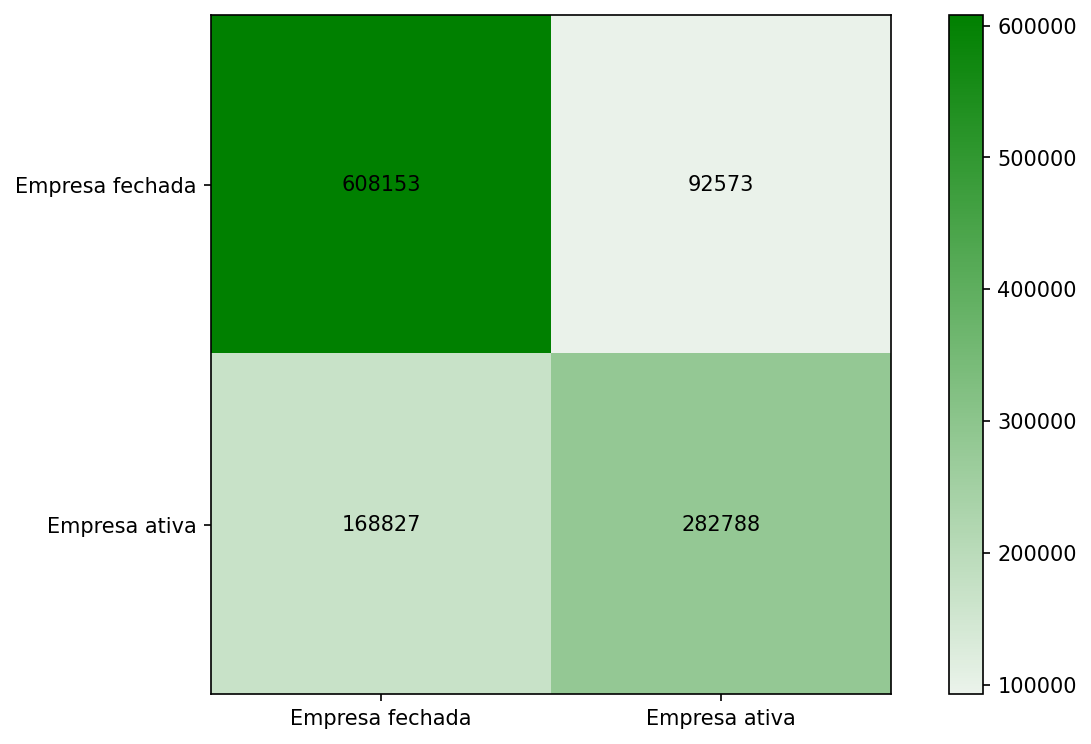

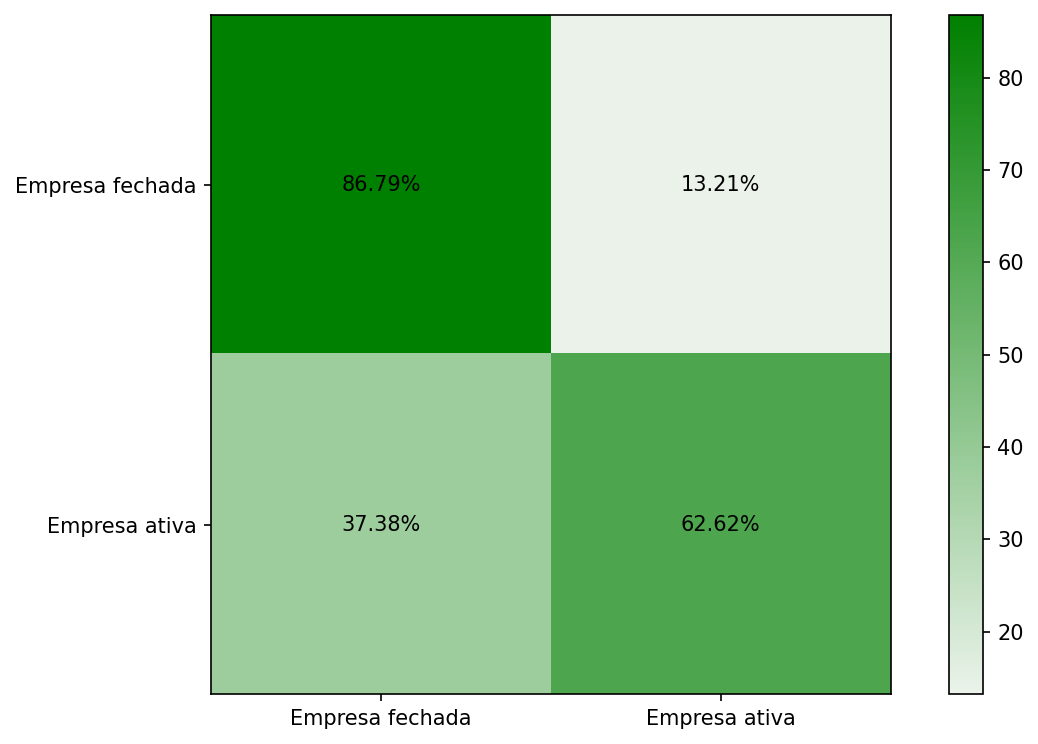

Matriz de Confusão:
 [[608153  92573]
 [168827 282788]]
Matriz de confusao percent [['86.79%' '13.21%']
 ['37.38%' '62.62%']]
Acurácia: 77.32%
F1 Score: 68.39%
Precision: 75.34%


In [24]:
plot_matriz(y_test, y_pred)

### Treinamento e avaliação do algoritmo Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier
#rf = RandomForestClassifier(max_depth=2)
rf = RandomForestClassifier(max_depth=10)


In [26]:
%%time
rf.fit(x_train_encoded, y_train)

Wall time: 9min 48s


RandomForestClassifier(max_depth=10)

In [27]:
y_pred = rf.predict(x_test_encoded)


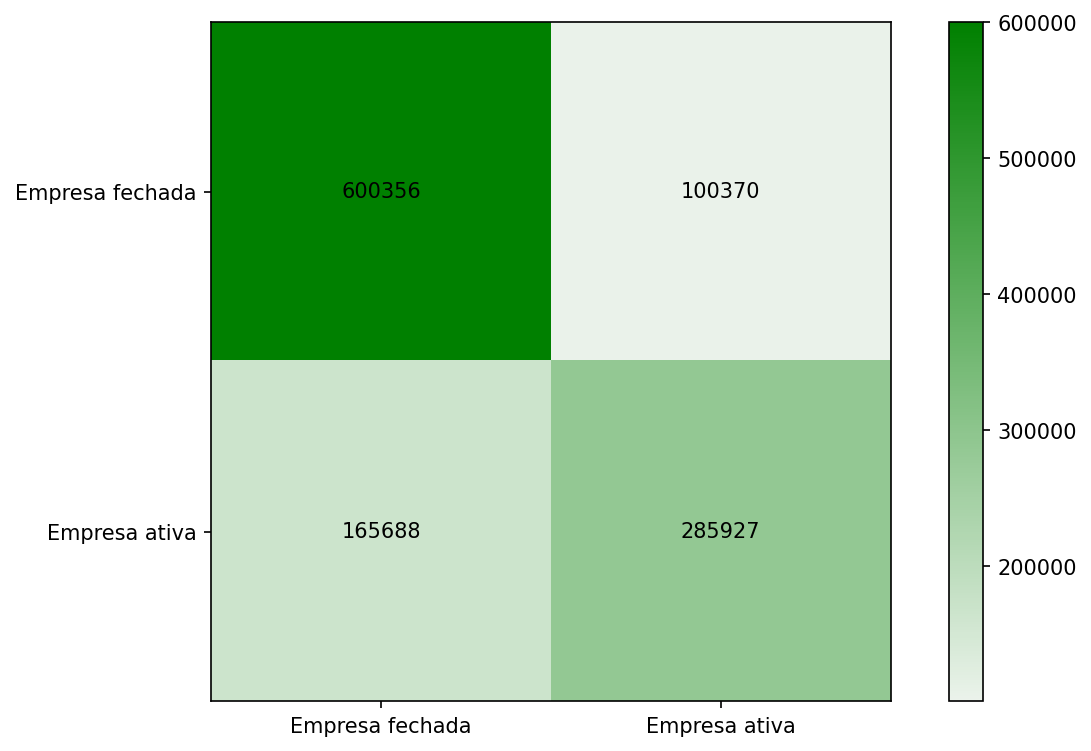

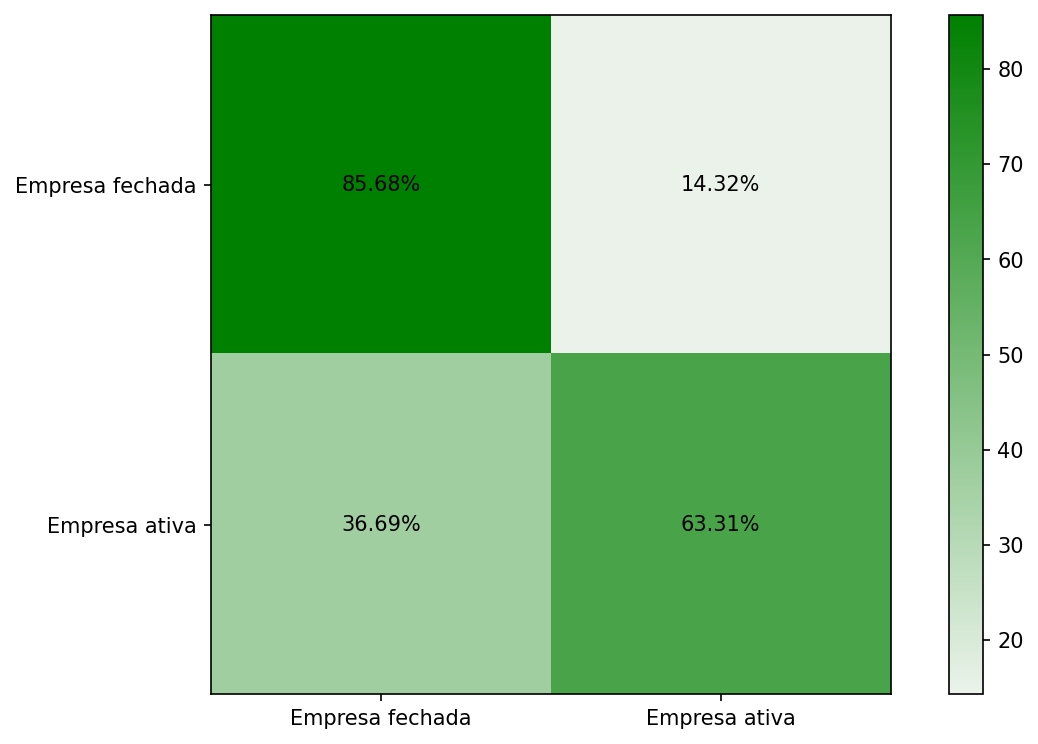

Matriz de Confusão:
 [[600356 100370]
 [165688 285927]]
Matriz de confusao percent [['85.68%' '14.32%']
 ['36.69%' '63.31%']]
Acurácia: 76.91%
F1 Score: 68.25%
Precision: 74.02%


In [28]:
plot_matriz(y_test, y_pred)

In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:\n", cm)
print("Acurácia: {:.2f}%".format(acc*100))

Matriz de Confusão:
 [[600356 100370]
 [165688 285927]]
Acurácia: 76.91%


### Definição e treinamento do algoritmo LightGBM

In [31]:
import lightgbm as lgb
train_data = lgb.Dataset(x_train_encoded,  label=y_train)
params = {
    "objective": "binary",
}

In [32]:
%%time
bst = lgb.LGBMClassifier(**params)
bst.fit(x_train_encoded, y_train)

Wall time: 16.6 s


LGBMClassifier(objective='binary')

In [33]:
import scipy.sparse as sp

sparse_matrix_csr = sp.csr_matrix(x_test_encoded)

y_pred = bst.predict(sparse_matrix_csr)

In [34]:
y_pred

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

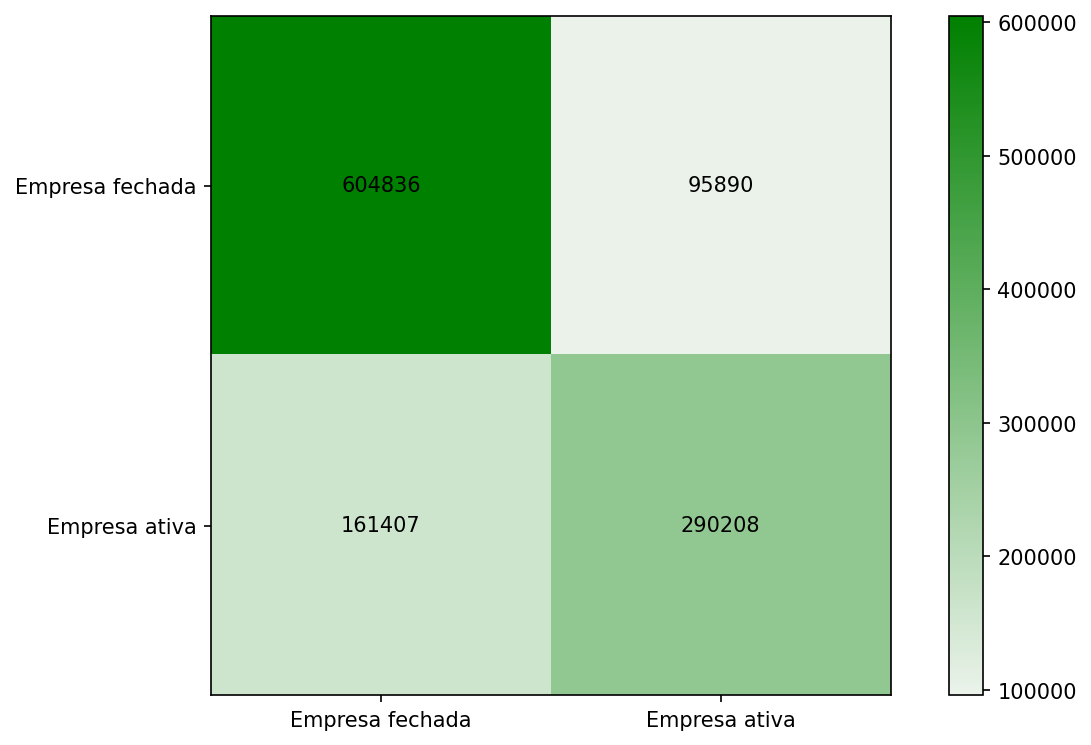

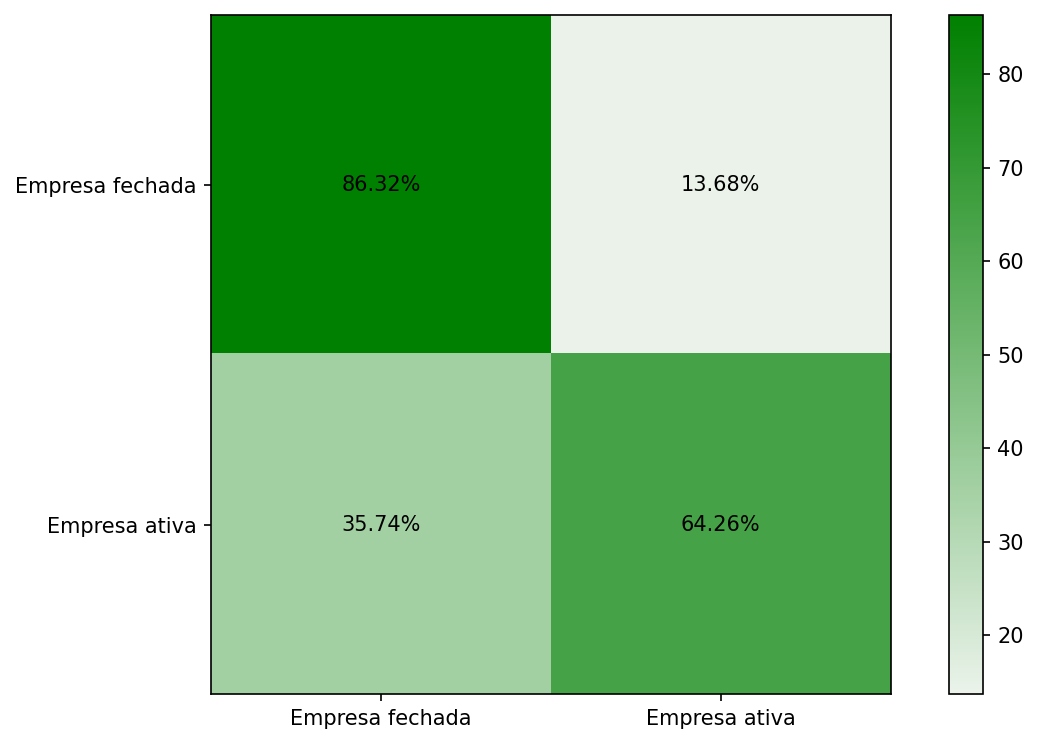

Matriz de Confusão:
 [[604836  95890]
 [161407 290208]]
Matriz de confusao percent [['86.32%' '13.68%']
 ['35.74%' '64.26%']]
Acurácia: 77.67%
F1 Score: 69.29%
Precision: 75.16%


In [35]:
plot_matriz(y_test, y_pred)

In [36]:
from sklearn.metrics import confusion_matrix, accuracy_score
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:\n", cm)
print("Acurácia: {:.2f}%".format(acc*100))

Matriz de Confusão:
 [[604836  95890]
 [161407 290208]]
Acurácia: 77.67%


### Obtendo as probabilidades previstas para cada classe, para cada modelo


In [42]:
y_pred_proba_rf = rf.predict_proba(x_test_encoded)
xgb_clf.feature_names = trained_xgb_features_names
y_pred_proba_xgb = xgb_clf.predict(dtest)
y_pred_proba_bst = bst.predict_proba(x_test_encoded)

In [43]:
y_pred_proba_rf

array([[0.57766185, 0.42233815],
       [0.504769  , 0.495231  ],
       [0.79204984, 0.20795016],
       ...,
       [0.26977472, 0.73022528],
       [0.48332667, 0.51667333],
       [0.71084393, 0.28915607]])

In [44]:
df = pd.DataFrame()
df['y_pred_proba_bst_1'] = [x[1] for x in y_pred_proba_bst]
df['y_pred_proba_rf_1'] = [x[1] for x in y_pred_proba_rf]
df['y_pred_proba_xgb_1'] =  y_pred_proba_xgb


In [45]:
df['y_test'] = y_test
df['y_test_str'] = [str(x) for x in y_test]

### Criação das visualizações de distribuição de propriedade utilizando Violin Plot para cada modelo

In [46]:
def plotViolinPlot(df, column_y_pred='y_pred_proba_bst_1'):
    sns.set(rc={'figure.figsize':(8,8)})
    plt.rcParams['figure.dpi'] = 150

    ax = sns.violinplot(  
         data=df
        , y='y_test_str'
        , x=column_y_pred
        , split=False
        , bw=.15
    )

    # Remove os labels dos eixos x e y
    ax.set(xlabel=None, ylabel=None)
    labels = ['Empresa ativa', 'Empresa fechada']
    colors = ['#1f77b4', '#ff7f0e']
    handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels))]
    plt.legend(handles, labels, loc='upper right', frameon=False)

    plt.show()


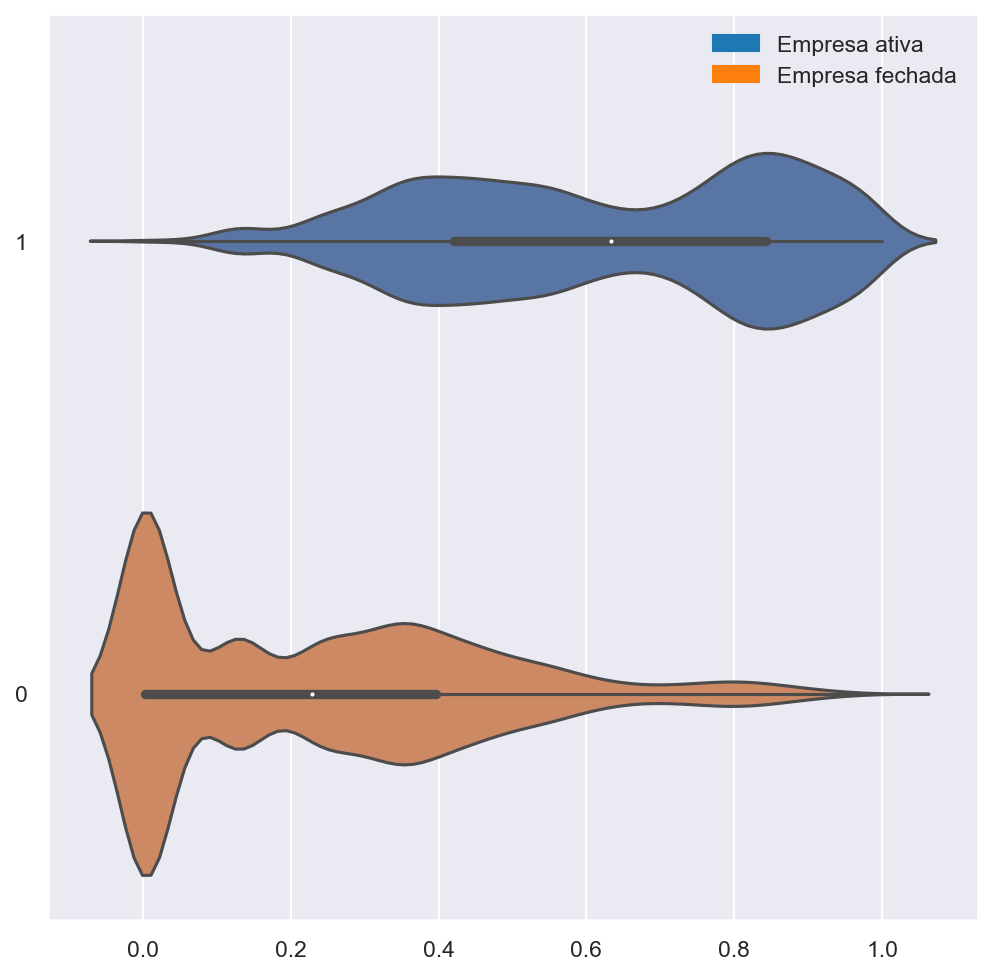

In [47]:
plotViolinPlot(df, column_y_pred='y_pred_proba_bst_1')

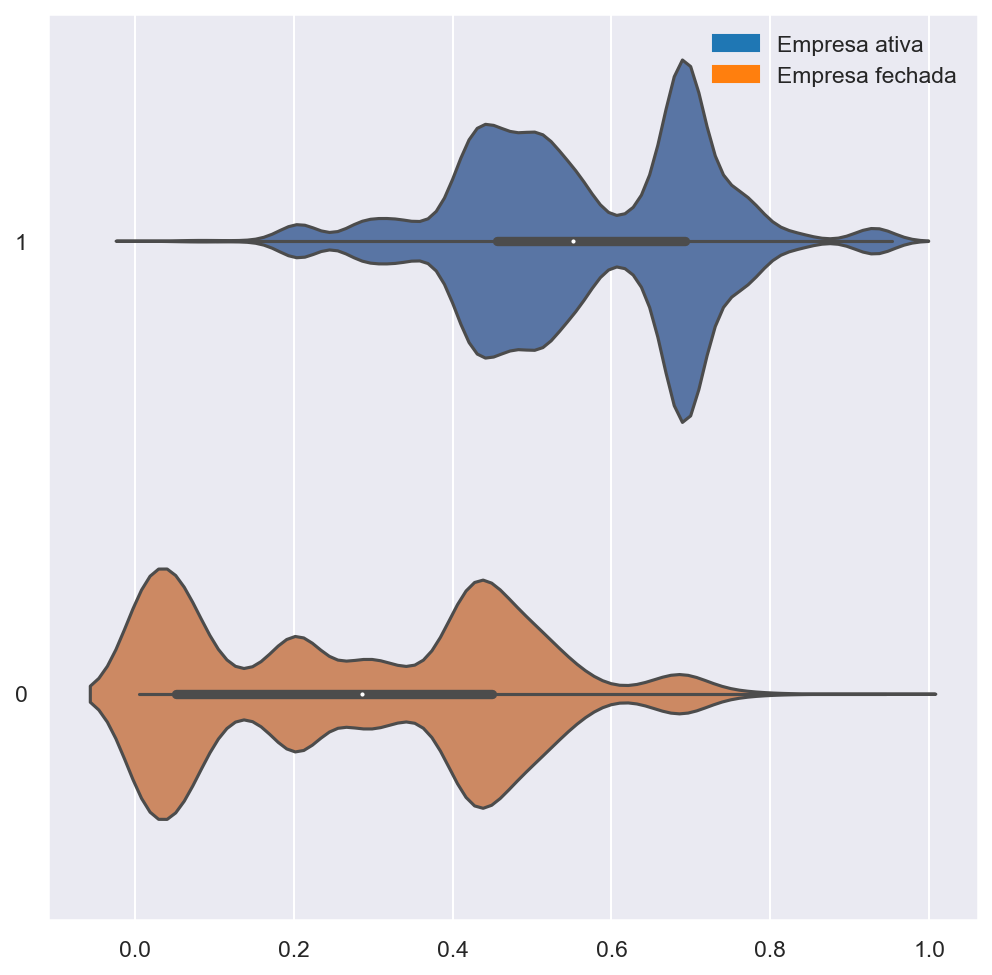

In [48]:
plotViolinPlot(df, column_y_pred='y_pred_proba_rf_1')

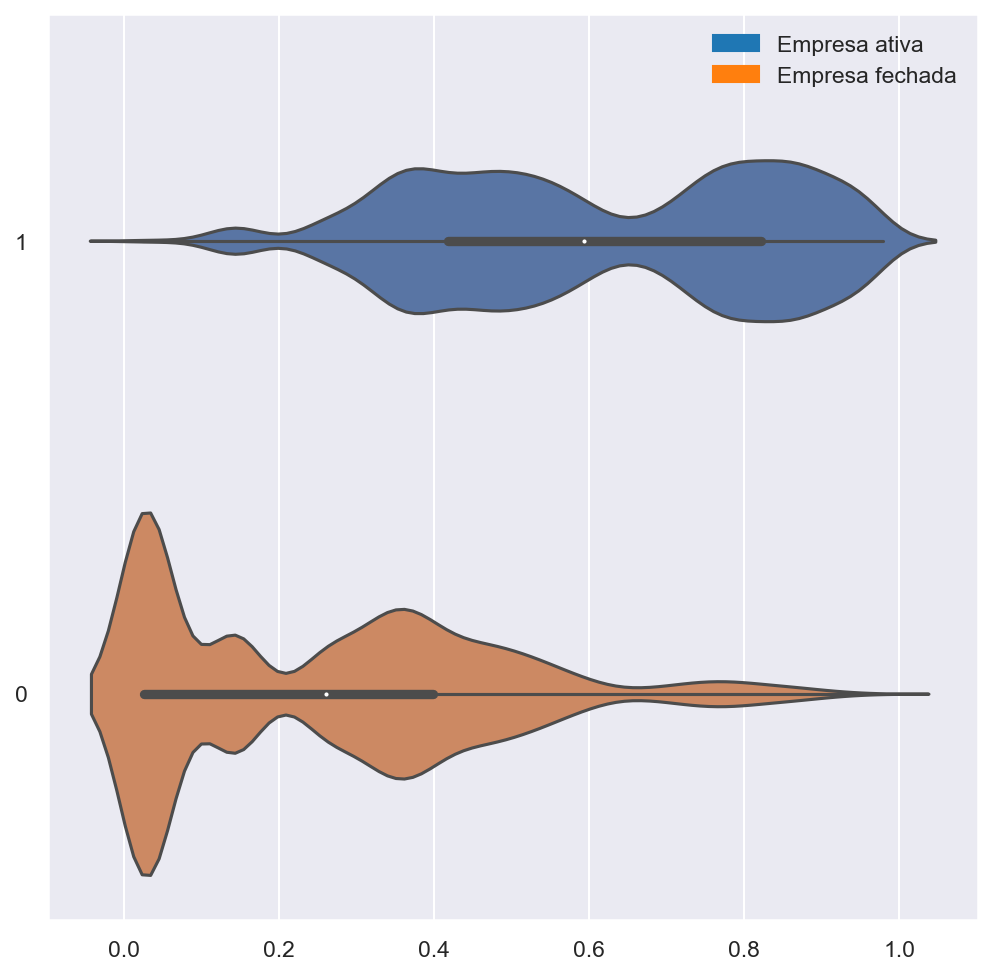

In [49]:
plotViolinPlot(df, column_y_pred='y_pred_proba_xgb_1')